### 下面我们将针对一场马拉松比赛的数据，使用seaborn绘制图形，分析数据得出一些有趣的结论

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# 读取数据
path = 'marathon-data.csv'
data = pd.read_csv(path)
data.head(3)

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42


In [3]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

#### 对原始数据进行处理，将显示时间的object类型字段，转换为timedelta类型

In [4]:
# 读取时直接转换时间
def convert_time(s):
    return pd.to_timedelta(s)
data2 = pd.read_csv('marathon-data.csv',converters={'split':convert_time,'final':convert_time})
data2.head(3)

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42


In [5]:
data2.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [6]:
# 读取后再进行时间类型转换
data['split'] = pd.to_timedelta(data['split'])
data['final'] = pd.to_timedelta(data['final'])
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [7]:
# 增加两列，存储把全程和半程时间转换为秒的数据
data['split_sec'] = data['split'].astype(int)/1e9
data['final_sec'] = data['final'].astype(int)/1e9
data['final_sec'][:3]

0    7731.0
1    7768.0
2    7842.0
Name: final_sec, dtype: float64

In [8]:
data.head(3)

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0


#### 绘制所有选手前半段耗时和总耗时的联合分布图，并画一条前后耗时都一样的辅助线，帮助区分

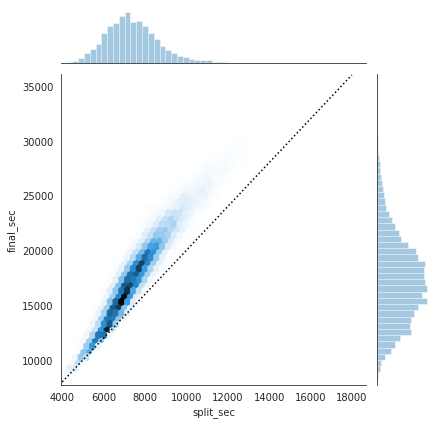

In [9]:
with sns.axes_style('white'):
    g = sns.jointplot("split_sec","final_sec",data,kind='hex')
    g.ax_joint.plot(np.linspace(4000,18000),np.linspace(8000,36000),':k')

#### 从图中不难看出，大部分选手的后半段耗时都比前半段要长

In [10]:
# 增加一列，用来区分，前半段耗时比后半段耗时短的选手，前半段耗时与后半段耗时相同或者更长的选手(负数表示前半段耗时比后半段长，正数则相反)
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head(3)

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443


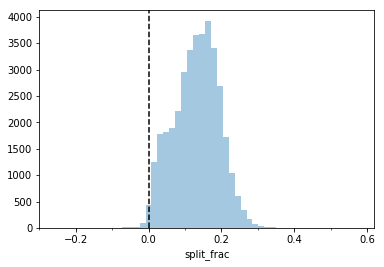

In [11]:
# 绘制柱状分布图，再次确认是不是很少有选手可以做到后半段加速的
g = sns.distplot(data['split_frac'],kde=False)
g.axvline(0,color='k',linestyle='--')
dist = np.round(np.arange(-0.3,0.7,0.1),1)
g.set_xticks(dist,[str(i) for i in dist])

In [12]:
# 我们来看看有几个大爷可以做到后半场加速的
data[data['split_frac']<0]['age'].count()

251

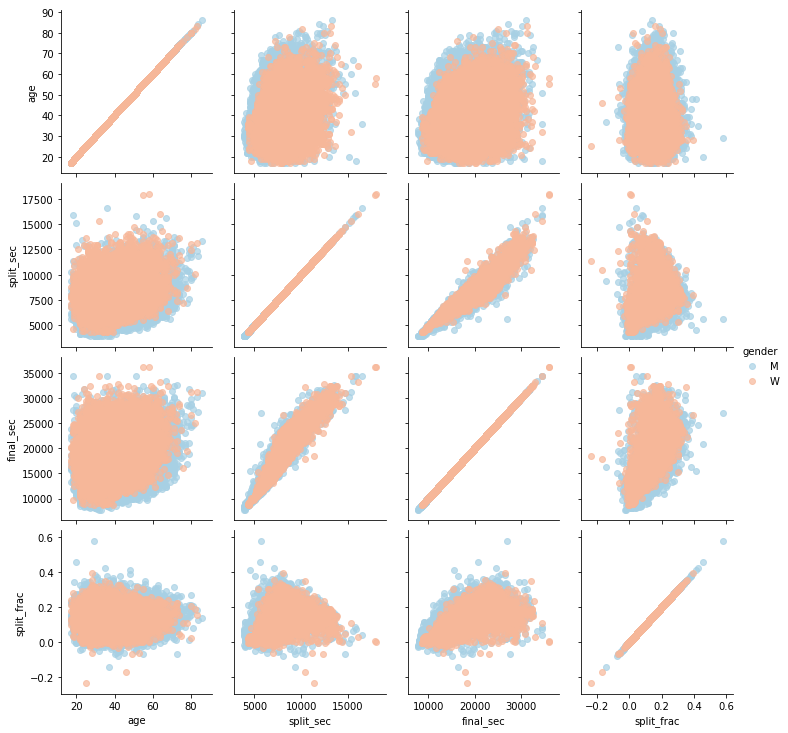

In [13]:
# 现在我们来画图看看不同性别的选手，不同比赛参数之间的关系 ['age','split_sec','final_sec','split_frac']
g = sns.PairGrid(data,vars=['age','split_sec','final_sec','split_frac'],hue='gender',palette='RdBu_r')
g.map(plt.scatter,alpha=0.7)
g.add_legend()

#### 分别查看男性和女性前后段加速选手的分布情况

Text(0.5, 0, 'split_frac')

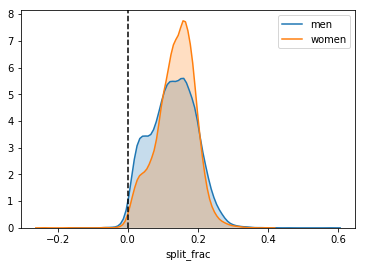

In [14]:
sns.kdeplot(data['split_frac'][data['gender']=='M'],label='men',shade=True)
g = sns.kdeplot(data['split_frac'][data['gender']=='W'],label='women',shade=True)
g.axvline(0,color='k',linestyle='--')
g.set_xlabel('split_frac')

#### 从图中不难看出后半段加速的男性选手比女性要多

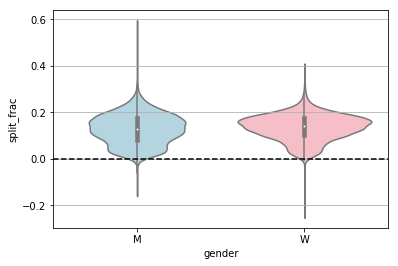

In [15]:
# 用蝴蝶图来查看男性和女性前后段加速选手分布
g = sns.violinplot('gender','split_frac',data=data,palette=['lightblue','lightpink'])
g.axhline(0,color='k',linestyle='--')
g.grid(axis='y')

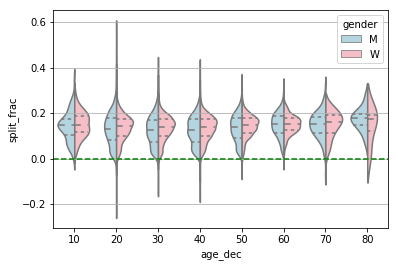

In [16]:
# 用年龄段、性别分类，绘制蝴蝶图来查看男性和女性前后段加速选手分布
# 增加年龄段这一列
data['age_dec'] = data['age'].map(lambda age:10*(age//10))
# 绘制蝴蝶图
with sns.axes_style(style=None):
    g = sns.violinplot("age_dec","split_frac",hue='gender',data=data,split=True,inner='quartile',palette=['lightblue','lightpink'])
    g.grid(axis='y')
    g.axhline(0,color='green',linestyle='--')

#### 我们发现80岁以上的女性成绩比80岁以上的男性好很多,是不是因为这个岁数的女性参赛的较少，我们看一眼

In [17]:
data.loc[data['gender']=='M'].loc[data['age']>=80]['age'].count()

11

In [18]:
data.loc[data['gender']=='W'].loc[data['age']>=80]['age'].count()

4

#### 果然80岁及以上参加比赛的男性比女性多很多